---

# Первичный анализ глобальной базы по поверке метеостанций

Импортируем библиотеки:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

Функции для визуализации:

In [2]:
def create_pie_chart(data, labels, title):
    plt.figure(figsize=(8, 8))
    plt.pie(data, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title(title)
    plt.axis('equal')
    plt.show()

def create_bar_chart(data, title, xlabel, ylabel, stacked=False):
    data.plot(kind='bar', stacked=stacked)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

def create_heatmap(data, title, xlabel, ylabel, annot=True, fmt='.1f', cmap='YlGnBu'):
    sns.heatmap(data, annot=annot, fmt=fmt, cmap=cmap)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

def create_histogram(data, title, xlabel, ylabel):
    plt.figure(figsize=(12, 8))
    for label, group_data in data:
        if label == 'СОКОЛ-М1': # Выделим нашу компанию
            alpha = 0.9
        else:
            alpha = 0.7
        plt.hist(group_data['verification_date'], bins=40, alpha=alpha, label=label)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

Загрузим данные и необходимые поля:

In [3]:
df = pd.read_excel('data/all_data.xlsx', usecols=[
    'mi.mitnumber',
    'mi.modification',
    'mi.number',
    'valid_date',
    'result_docnum',
    'result_text',
    'mi.mitype',
    'mi.mititle',
    'org_title',
    'vri_id',
    'verification_date'
])

Выведем первые пять строк и основную информацию о датафрейме:

In [4]:
df.head()

,mi.mitnumber,mi.modification,mi.number,valid_date,result_docnum,result_text,mi.mitype,mi.mititle,org_title,vri_id,verification_date
0,40331-14,Vantage Pro2,BF200803012,2024-10-16T00:00:00Z,С-ДЮП/17-10-2023/287418480,Пригодно,Vantage Pro2,Станции автоматические метеорологические,ООО «ПРОММАШ ТЕСТ МЕТРОЛОГИЯ»,1-287418480,2023-10-17T00:00:00Z
1,40331-14,Vantage Pro2,BF230221033,2024-10-12T00:00:00Z,С-ДЮП/13-10-2023/286964248,Пригодно,Vantage Pro2,Станции автоматические метеорологические,ООО «ПРОММАШ ТЕСТ МЕТРОЛОГИЯ»,1-286964248,2023-10-13T00:00:00Z
2,40331-14,Vantage Pro2,BE181206037,2024-10-12T00:00:00Z,С-ТТ/13-10-2023/286487854,Пригодно,Vantage Pro2,Станции автоматические метеорологические,"ФБУ ""РОСТЕСТ-МОСКВА""",1-286487854,2023-10-13T00:00:00Z
3,40331-14,Vantage Pro2,AS160104035,2024-10-11T00:00:00Z,С-ТТ/12-10-2023/285945170,Пригодно,Vantage Pro2,Станции автоматические метеорологические,"ФБУ ""РОСТЕСТ-МОСКВА""",1-285945170,2023-10-12T00:00:00Z
4,40331-14,Vantage Pro2,BC180723020,2024-10-11T00:00:00Z,С-БТЦ/12-10-2023/286180957,Пригодно,Vantage Pro2,Станции автоматические метеорологические,"ФГБУ ""ЦЕНТРАЛЬНОЕ УГМС""",1-286180957,2023-10-12T00:00:00Z


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9971 entries, 0 to 9970
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   mi.mitnumber       9971 non-null   object
 1   mi.modification    9596 non-null   object
 2   mi.number          9971 non-null   object
 3   valid_date         9331 non-null   object
 4   result_docnum      9971 non-null   object
 5   result_text        9971 non-null   object
 6   mi.mitype          9971 non-null   object
 7   mi.mititle         9971 non-null   object
 8   org_title          9971 non-null   object
 9   vri_id             9971 non-null   object
 10  verification_date  9971 non-null   object
dtypes: object(11)
memory usage: 857.0+ KB


Есть пропуски в полях `mi.modification` и `valid_date`. Пропуски здесь несут информацию: если поля не заполнены - у метеостанции (средства измерения, далее - СИ) нет наименования модификации и метеостанция (СИ) не прошла поверку соответственно.

Преобразуем тип данных в полях `valid_date` и `verification_date` в `pd.datetime` без тайм-зоны:

In [6]:
df['valid_date'] = pd.to_datetime(df['valid_date']).dt.tz_localize(None)
df['verification_date'] = pd.to_datetime(df['verification_date']).dt.tz_localize(None)

Вычислим диапазон дат поверки метеостанций (СИ) в базе данных:

In [7]:
min(df['verification_date']), max(df['verification_date'])

(Timestamp('2018-02-05 12:00:00'), Timestamp('2023-10-17 00:00:00'))

Отсортируем датафрейм по `mi.number` и `verification_date` для определения первичных поверок и возраста метеостанции (СИ):

In [8]:
df = df.sort_values(by=['mi.number', 'verification_date']).copy()

Сгенерируем поле `check` - тип поверки (периодическая или первичная). Поверка является первичной, если уникальный номер метеостанции (СИ) встречается впервые и результат поверки - "Пригодно", в ином случае поверка периодическая.

In [9]:
df['check'] = 'Периодическая'
first_check_mask = (df['result_text'] == 'Пригодно') & ~df.duplicated(subset='mi.number', keep='first')
df.loc[first_check_mask, 'check'] = 'Первичная'

Сгенерируем поле `station_age` - возраст метеостанции (СИ) от первичной поверки в годах, будем округлять до целого.

In [10]:
first_check_date = df[first_check_mask].groupby('mi.number')['verification_date'].min()
df['station_age'] = (df['verification_date'] - df['mi.number'].map(first_check_date)).dt.days // 365

Сгенерируем поле `verification_year` - год верификации.

In [11]:
df['verification_year'] = df['verification_date'].dt.year

Посмотрим, сколько всего метеостанций (СИ) проходили поверку:

In [12]:
df['mi.number'].value_counts()

12              37
8               34
7               33
19              33
17              32
                ..
051865           1
051876           1
051877           1
051921           1
в.н 418381/1     1
Name: mi.number, Length: 5029, dtype: int64

Всего 5029 метеостанций (СИ).

Напишем функцию, для создания поля с названием производителя метеостанции (СИ):

In [13]:
def rename_mitype(mitype):
    if 'Vantage Pro' in mitype:
        return 'Davis'
    elif 'WXT' in mitype:
        return 'Vaisala'
    elif 'PWS' in mitype:
        return 'ICB'
    elif 'WS-UMB' in mitype:
        return 'Lufft'
    elif 'M-49M' in mitype:
        return 'Сафоновский'
    elif 'СОКОЛ-М1' in mitype:
        return 'СОКОЛ-М1'
    elif any(item in mitype for item in ['ДВН', 'ДВС', 'ДО', 'ДВГ', 'ДТВ', 'ДД']):
        return 'Минимакс-94'
    return mitype

In [14]:
df['mi.manufacturer'] = df['mi.mitype'].apply(rename_mitype)

Построим круговую диаграмму с долей производителей метеостанций (СИ), проходящих поверку:

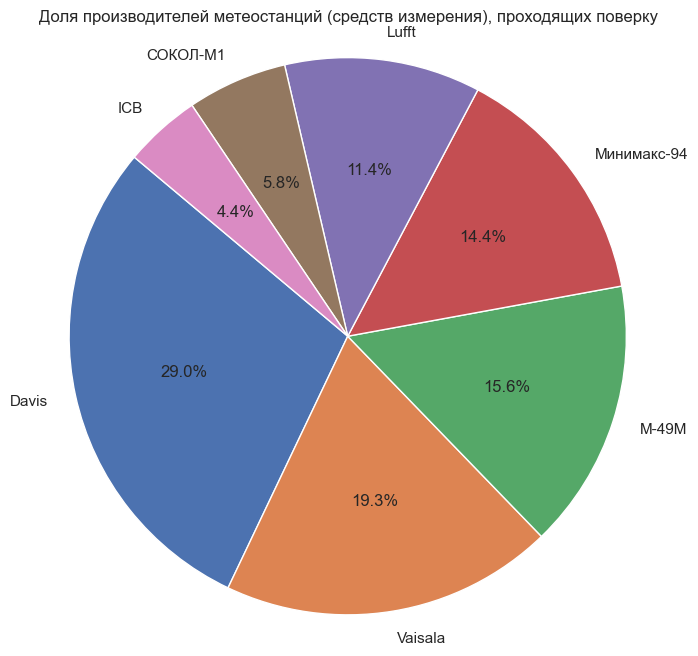

In [15]:
mi_type_counts = df['mi.manufacturer'].value_counts()
create_pie_chart(mi_type_counts, mi_type_counts.index, 'Доля производителей метеостанций (средств измерения), проходящих поверку')

Важно отметить, что производитель "Минимакс-94" производит именно СИ - датчики, а не метеостанции. Посмотрим круговую диаграмму типов СИ, производимых этим производителем:

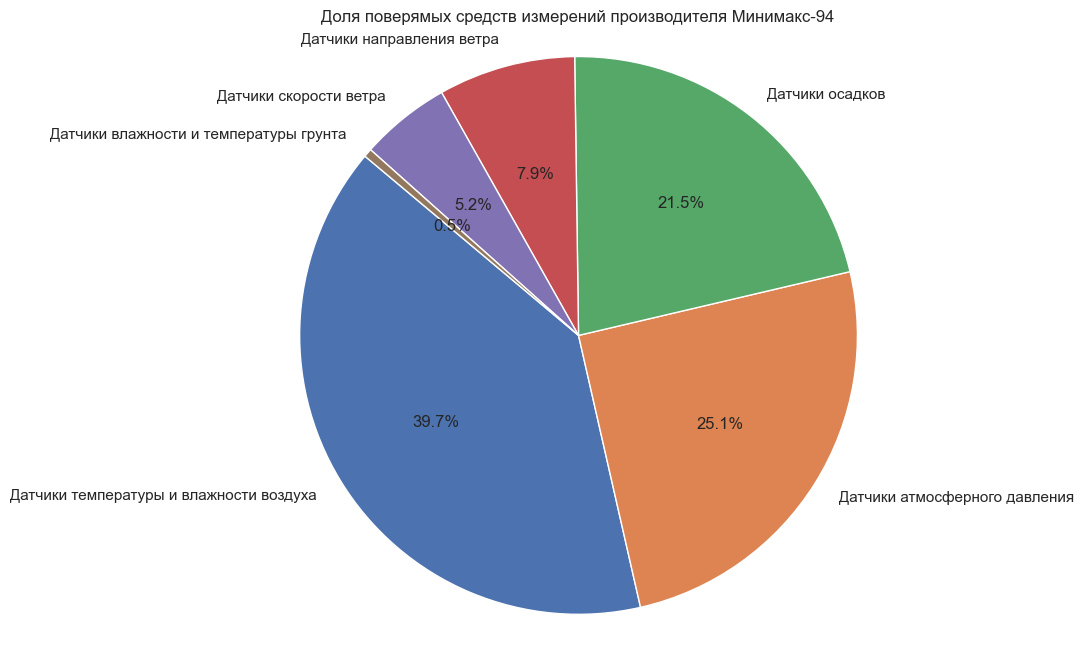

In [16]:
mi_type_counts = df[df['mi.manufacturer'] == 'Минимакс-94']['mi.mititle'].value_counts()
create_pie_chart(mi_type_counts, mi_type_counts.index, 'Доля поверямых средств измерений производителя Минимакс-94')

Представим в виде барового графика число поверок каждого производителя с разбивкой по типу поверки:

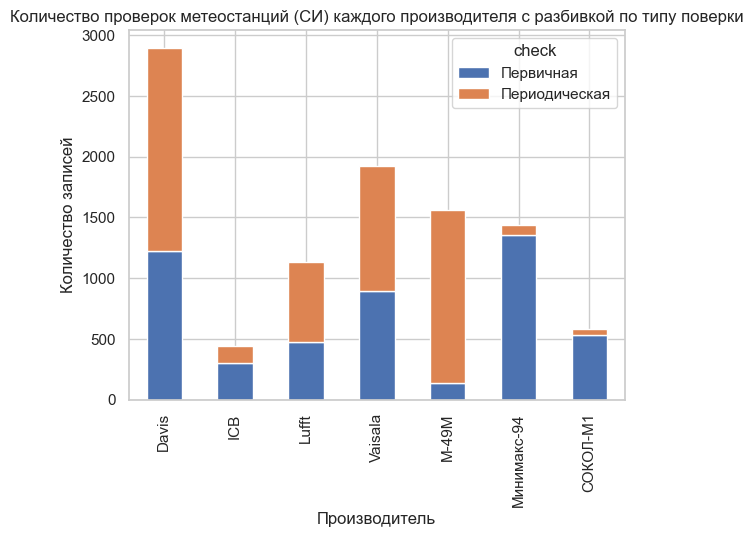

In [17]:
mi_type_check_counts = df.groupby(['mi.manufacturer', 'check']).size().unstack()
create_bar_chart(
    mi_type_check_counts, 
    'Количество проверок метеостанций (СИ) каждого производителя с разбивкой по типу поверки', 
    'Производитель', 
    'Количество записей', 
    stacked=True)

Представим в виде барового графика средний возраст метеостанций (СИ) каждого производителя:

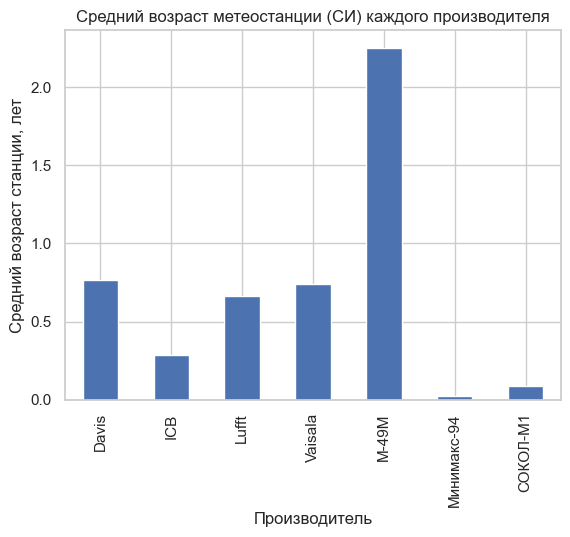

In [18]:
mi_type_avg_station_age = df.groupby('mi.manufacturer')['station_age'].mean()
create_bar_chart(
    mi_type_avg_station_age, 
    'Средний возраст метеостанции (СИ) каждого производителя', 
    'Производитель', 
    'Средний возраст станции, лет'
    )

Представим распределение возраста метеостанций (СИ) для каждого производителя в качестве гистограмм:

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:703: FutureWarning: iteritems is deprecated and will be r

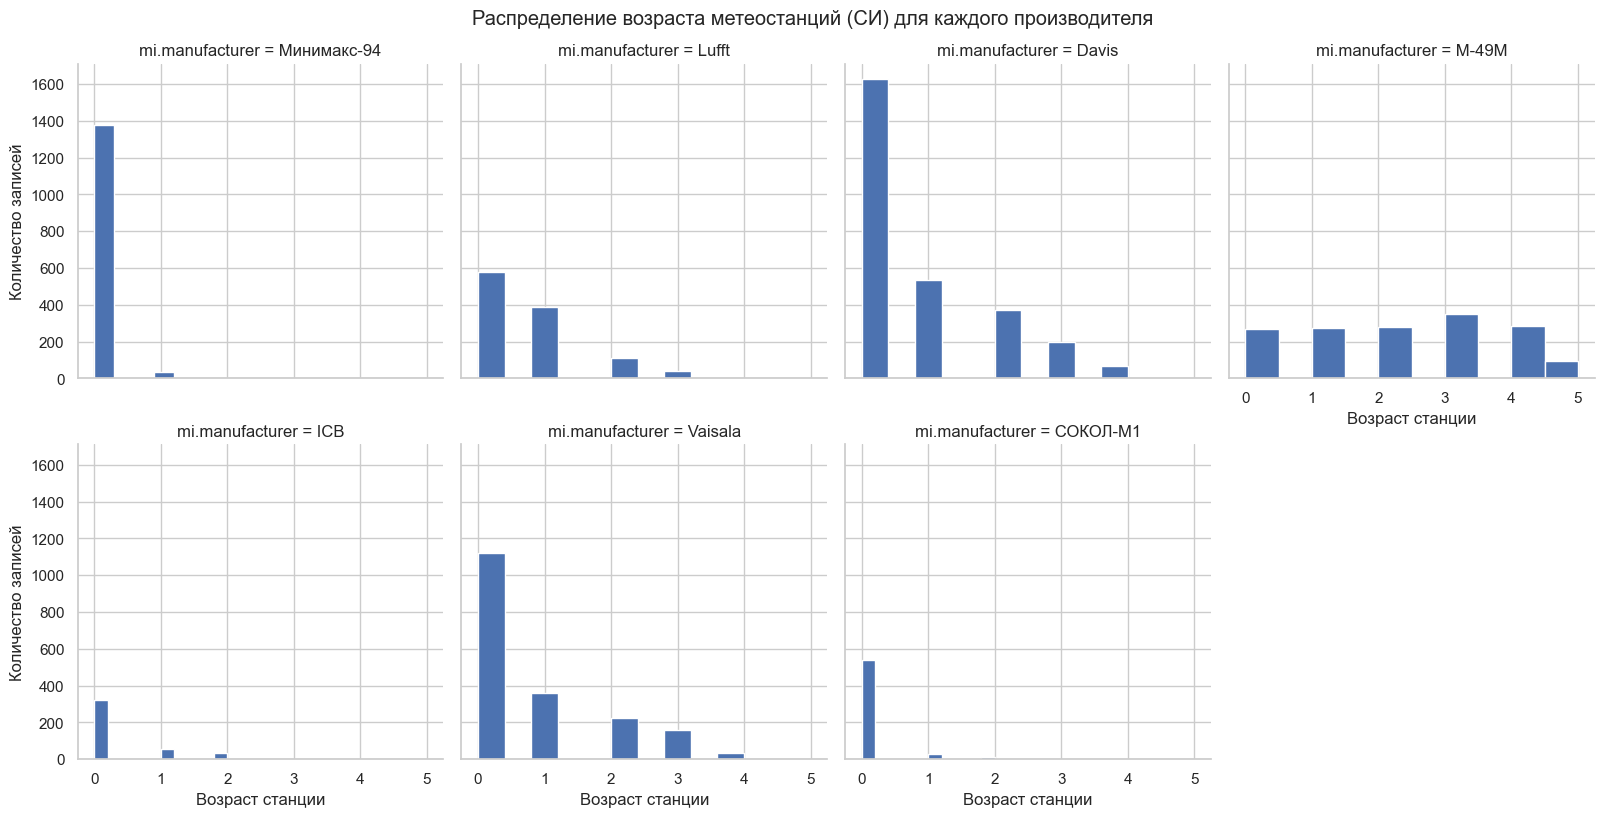

In [19]:
g = sns.FacetGrid(df, col="mi.manufacturer", height=4, col_wrap=4)
g.map(plt.hist, 'station_age', bins=10)
g.set_axis_labels('Возраст станции', 'Количество записей')
plt.suptitle('Распределение возраста метеостанций (СИ) для каждого производителя', y=1.02)
plt.show()

Представим в виде тепловой карты количество поверок метеостанций (СИ) каждого производителя с разбивкой по типу и результату поверки:

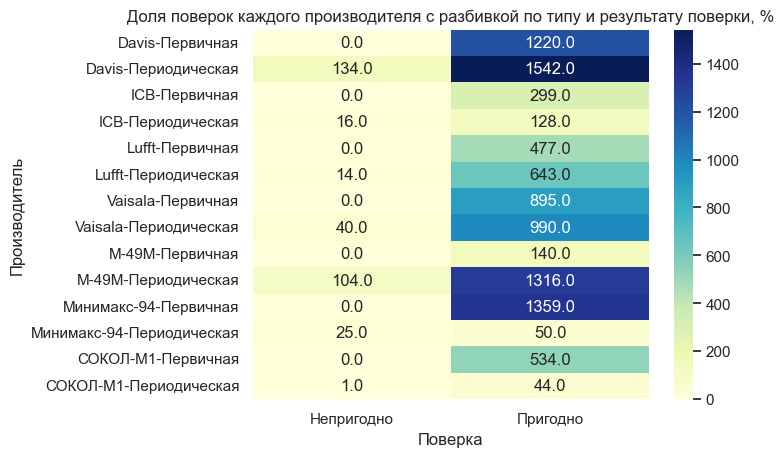

In [20]:
mi_type_check_result_counts = df.groupby(['mi.manufacturer', 'check', 'result_text']).size().unstack().fillna(0)
create_heatmap(
    mi_type_check_result_counts, 
    'Доля поверок каждого производителя с разбивкой по типу и результату поверки, %', 
    'Поверка', 
    'Производитель')

И долю таких поверок:

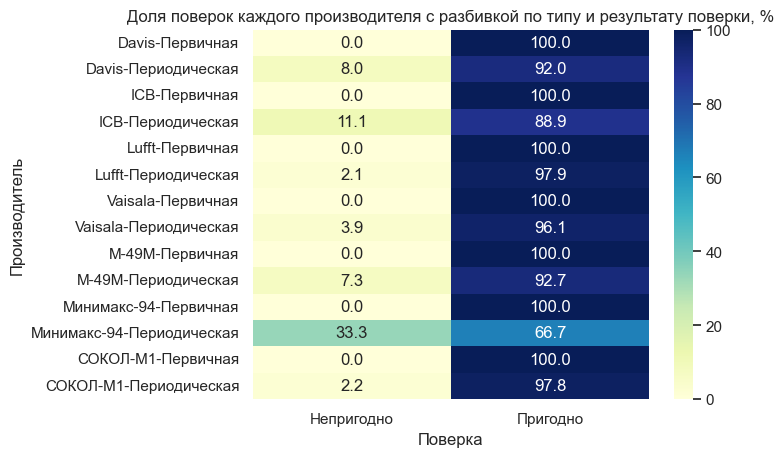

In [21]:
mi_type_check_result_percentages = mi_type_check_result_counts.div(mi_type_check_result_counts.sum(axis=1), axis=0) * 100
create_heatmap(
    mi_type_check_result_percentages, 
    'Доля поверок каждого производителя с разбивкой по типу и результату поверки, %', 
    'Поверка', 
    'Производитель')

Представим в виде гистограммы число поверок по датам для каждого производителя:

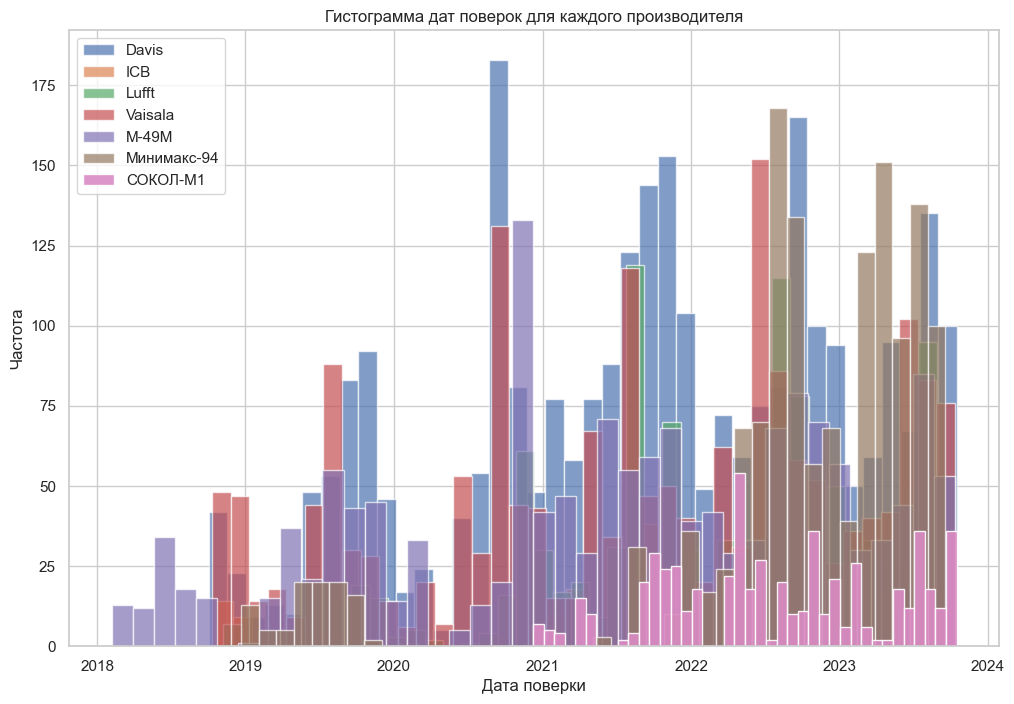

In [22]:
manufacturer_groups = df.groupby('mi.manufacturer')
create_histogram(
    manufacturer_groups, 
    'Гистограмма дат поверок для каждого производителя', 
    'Дата поверки', 
    'Частота'
)

Также большой интерес представляют данные о первичной поверке метеостанций (СИ), эта информация говорит о том, сколько производитель продавал метеостанций (СИ) ежегодно:

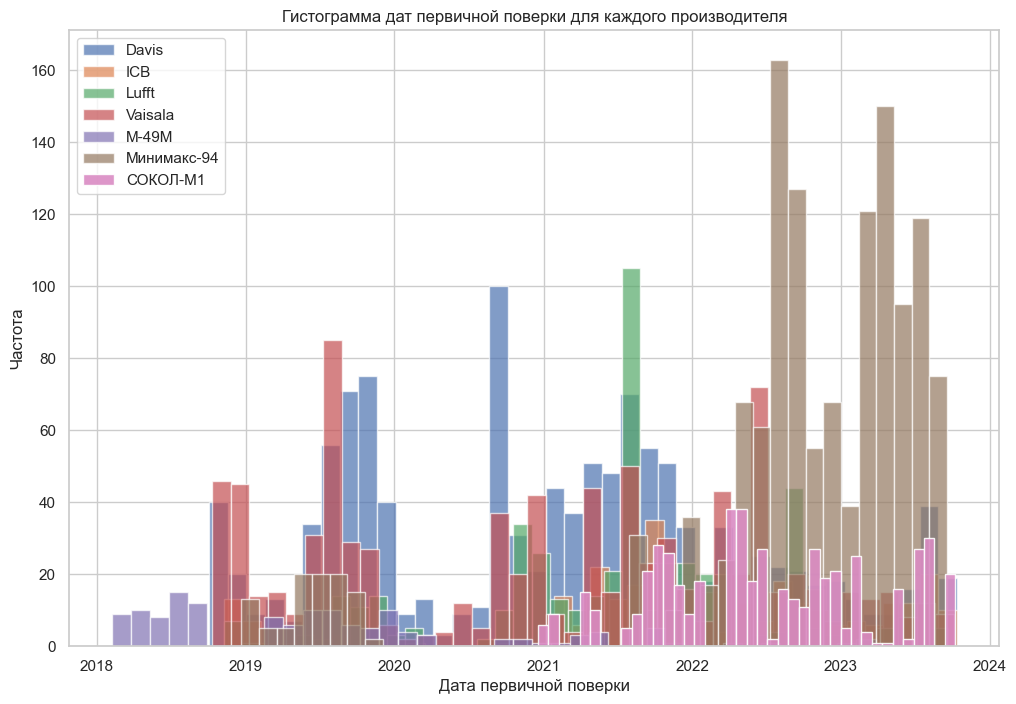

In [23]:
manufacturer_groups_primary = df[df['check'] == 'Первичная'].groupby('mi.manufacturer')
create_histogram(
    manufacturer_groups_primary,
      'Гистограмма дат первичной поверки для каждого производителя', 
      'Дата первичной поверки', 
      'Частота'
)

Построим сводную таблицу по числу поверок:

In [24]:
pivot_table = df.pivot_table(
    index=['check', 'mi.manufacturer'], 
    columns='verification_year', 
    values='mi.mitnumber', 
    aggfunc='count', 
    fill_value=0
)
pivot_table

verification_year              2018  2019  2020  2021  2022  2023
check         mi.manufacturer                                    
Первичная     Davis              60   305   197   389   164   105
              ICB                20     3     3   120    86    67
              Lufft               8    49    68   228   100    24
              Vaisala            91   216   125   191   200    72
              М-49М              54    55    12    14     3     2
              Минимакс-94        13    87     0    77   583   599
              СОКОЛ-М1            0     0     6   149   248   131
Периодическая Davis               5    49   255   429   528   410
              ICB                 3     0     7    20    50    64
              Lufft               0     9    39    86   284   239
              Vaisala             4    29   208   195   285   309
              М-49М              38   168   228   360   374   252
              Минимакс-94         0     1     0     3    23    48
              СОКОЛ-М1            0     0     1     0     1    43

Сохраним данные с новыми полями и сводную таблицу:

In [29]:
with pd.ExcelWriter('data/all_data_with_new_columns.xlsx', engine='openpyxl') as writer:

    df.to_excel(writer, index=False, sheet_name='all_data')

    pivot_table.to_excel(writer, sheet_name='pivot_table')

---